# Plot 1950-2017 change for the multi-model mean (supp fig)

In [1]:
import sys
sys.path.append('/home/ysilvy/Density_bining/Yona_analysis/programs/')
import os, glob
from netCDF4 import Dataset as open_ncfile
import matplotlib.pyplot as plt
from maps_matplot_lib import defVarmme, zon_2Dz, custom_div_cmap, modelagree, zonal_2D
from lib_remapping import remaptoz
import numpy as np
import datetime
import pickle
import xarray as xr
from functions import lag_linregress_3D

## Read every run and compute trend 

In [2]:
# == Read models ==
from modelsDef import defModels

models = defModels()

indir_histrcp85 = '/home/ysilvy/Density_bining/Yona_analysis/data/hist_rcp85/'
time = np.arange(1950,2101)

# Choose where to end time series
y2 = 2017 
trend_models = [0]*11
vart_models = [0]*11
model_names = ['']*11
bowl_models = [0]*11
imod=0

for i, model in enumerate(models):
#i=2; model=models[i]
    # Read hist+rcp85 files
    listruns = sorted(glob.glob(indir_histrcp85 + 'cmip5.' + model['name'] + '.' + '*zon2D.nc'))
    listruns1d = sorted(glob.glob(indir_histrcp85 + 'cmip5.' + model['name'] + '.' + '*zon1D.nc'))
    nruns = len(listruns)
    if nruns != 0:
        print('Working on', model['name'])
        # Index of common time interval
        tstart = model['props'][2]
        tend = model['props'][3] #2005
        # Loop over number of runs
        for k in range(nruns):
            namefile = os.path.basename(listruns[k])
            run_nb = namefile.split('.')[3]
            print('    . run number', k, run_nb)

            fhrcp = xr.open_dataset(listruns[k],decode_times=False)
            varkt = fhrcp.isonso.isel(time=slice(tstart+89,tend+95)) #1950-2100
            varkt['time'] = time
            varkt = varkt.sel(time=slice(1950,y2))
            fhrcp1d = xr.open_dataset(listruns1d[k],decode_times=False)
            bowlk = fhrcp1d.ptopsigma.isel(time=slice(tstart+89,tend+95))
            bowlk['time'] = time
            bowlk = bowlk.sel(time=slice(1950,y2)).mean(dim='time')

            # Compute trend at each grid point
            covk,cork,slopek,interceptk,pvalk,stderrk = lag_linregress_3D(x=varkt.time,y=varkt)
            trendk = slopek*len(varkt.time) 
            
            # Add dimension to stack members
            trendk['members'] = run_nb
            trendk = trendk.expand_dims('members') 
            varkt['members'] = run_nb
            varkt = varkt.expand_dims('members') 
            bowlk['members'] = run_nb
            bowlk = bowlk.expand_dims('members') 
            if k==0:
                trend_mod = trendk
                bowl_mod = bowlk
                vart_mod = varkt
            else:
                trend_mod = xr.concat([trend_mod,trendk],dim='members')
                bowl_mod = xr.concat([bowl_mod,bowlk],dim='members')
                vart_mod = xr.concat([vart_mod,varkt],dim='members')
            
        trend_models[imod] = trend_mod
        model_names[imod] = model['name']
        bowl_models[imod] = bowl_mod
        vart_models[imod] = vart_mod
        imod=imod+1
        

Working on CanESM2
    . run number 0 r1i1p1


/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/xarray/core/computation.py:603: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:18

    . run number 1 r2i1p1
    . run number 2 r3i1p1
    . run number 3 r4i1p1
    . run number 4 r5i1p1
Working on CCSM4
    . run number 0 r1i1p1
    . run number 1 r2i1p1
    . run number 2 r3i1p1
    . run number 3 r4i1p1
    . run number 4 r5i1p1
    . run number 5 r6i1p1
Working on CESM1-CAM5
    . run number 0 r1i1p1
    . run number 1 r2i1p1
    . run number 2 r3i1p1
Working on CSIRO-Mk3-6-0
    . run number 0 r1i1p1
    . run number 1 r2i1p1
    . run number 2 r3i1p1
    . run number 3 r4i1p1
    . run number 4 r5i1p1
    . run number 5 r6i1p1
    . run number 6 r7i1p1
    . run number 7 r8i1p1
    . run number 8 r9i1p1
Working on FGOALS-g2
    . run number 0 r1i1p1
Working on GISS-E2-R
    . run number 0 r1i1p1
    . run number 1 r2i1p1
    . run number 2 r2i1p3
Working on HadGEM2-ES
    . run number 0 r1i1p1
    . run number 1 r3i1p1
Working on IPSL-CM5A-LR
    . run number 0 r2i1p1
    . run number 1 r3i1p1
    . run number 2 r4i1p1
Working on IPSL-CM5A-MR
    . run number 0

## Compute ensemble means

In [3]:
basin = trend_models[0].basin; basinN = len(basin)
lat = trend_models[0].latitude; latN = len(lat)
lev = trend_models[0].lev; levN = len(lev)
time = vart_models[0].time; timeN = len(time)
trend_means = xr.DataArray(np.zeros((len(trend_models),basinN,levN,latN)),dims=['models','basin','lev','latitude'],
                             coords=[model_names,basin,lev,lat])
bowl_means = xr.DataArray(np.zeros((len(trend_models),basinN,latN)),dims=['models','basin','latitude'],
                             coords=[model_names,basin,lat])
vart_means = xr.DataArray(np.zeros((len(trend_models),timeN,basinN,levN,latN)),dims=['models','time','basin','lev','latitude'],
                             coords=[model_names,time,basin,lev,lat])
#sign_means = xr.zeros_like(trend_means)
for i in range(len(trend_models)):
    trend_means[i,:,:,:] = trend_models[i].mean(dim='members')
    bowl_means[i,:,:] = bowl_models[i].mean(dim='members')
    vart_means[i,:,:,:,:] = vart_models[i].mean(dim='members')

## Compute multi-model means

In [4]:
trend_mmm = trend_means.mean(dim='models')
bowl_mmm = bowl_means.mean(dim='models')
vart_mmm = vart_means.mean(dim='models')

## Define model agreement from sign of trends 

In [5]:
sign = xr.ufuncs.sign(trend_means)
signpos = xr.DataArray(np.count_nonzero(sign==1,axis=0),dims=['basin','lev','latitude'],coords=[basin,lev,lat]).astype(float)
signneg = xr.DataArray(np.count_nonzero(sign==-1,axis=0),dims=['basin','lev','latitude'],coords=[basin,lev,lat]).astype(float)
model_agree = xr.ufuncs.maximum(signpos,signneg)/11#(signpos+signneg)

In [6]:
model_agree=model_agree.where(np.isnan(trend_mmm)==False)

In [8]:
# -- Define variable properties
varname = defVarmme('salinity'); v = 'S'
var = varname['var_zonal_w/bowl']

minmax = varname['minmax_zonal']
clevsm = varname['clevsm_zonal']
clevsm_bold = varname['clevsm_bold']
legVar = varname['legVar']
unit = varname['unit']

# -- Show isopycnals
show_isopyc = True

# -- Density domain
rhomin = 21
rhomid = 26
rhomax = 28
domrho = [rhomin, rhomid, rhomax]

# -- Now mask points in the bowl
for ilat in range(latN):
    if np.isnan(bowl_mmm[1,ilat]) == False :
        inda = np.ma.nonzero(bowl_mmm[1,ilat]>=lev)[0]
        trend_mmm[1,inda,ilat] = np.nan
        trend_means[:,1,inda,ilat] = np.nan
        model_agree[1,inda,ilat] = np.nan
    if np.isnan(bowl_mmm[2,ilat]) == False :
        indp = np.ma.nonzero(bowl_mmm[2,ilat]>=lev)[0]
        trend_mmm[2,indp,ilat] = np.nan
        trend_means[:,2,indp,ilat] = np.nan
        model_agree[2,indp,ilat] = np.nan
    if np.isnan(bowl_mmm[3,ilat]) == False :
        indi = np.ma.nonzero(bowl_mmm[3,ilat]>=lev)[0]
        trend_mmm[3,indi,ilat] = np.nan
        trend_means[:,3,indi,ilat] = np.nan
        model_agree[3,indi,ilat] = np.nan

In [9]:
# ===== Create variable bundles =====
varPac = {'name': 'Pacific', 'var_change': trend_mmm.sel(basin=2), 'var_mean': None,
          'bowl1': None, 'bowl2': None, 'labBowl': None}
varAtl = {'name': 'Atlantic', 'var_change': trend_mmm.sel(basin=1), 'var_mean': None, 
          'bowl1': None, 'bowl2': None, 'labBowl': None}
varInd = {'name': 'Indian', 'var_change': trend_mmm.sel(basin=3), 'var_mean': None, 
          'bowl1': None, 'bowl2': None, 'labBowl': None}

In [12]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.5

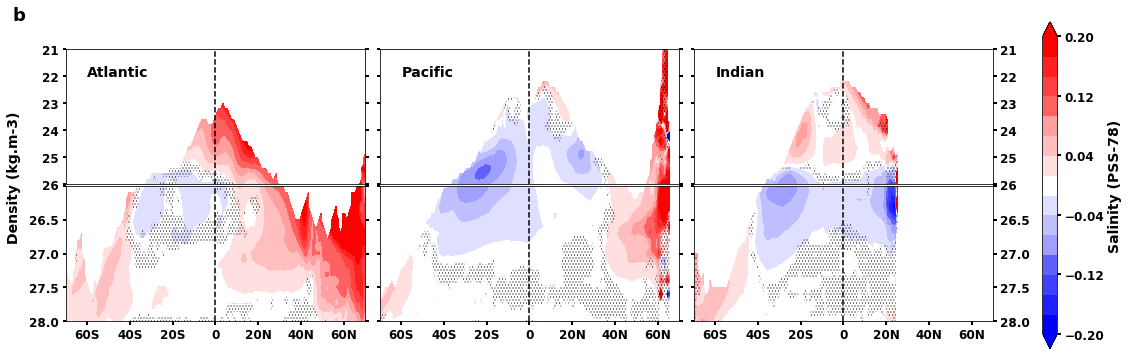

In [16]:
# ===== Plot =====
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17,5))

levels = np.linspace(minmax[0], minmax[1], minmax[2])
cmap = custom_div_cmap() # plt.get_cmap('bwr')

agreelev = 0.6

cnplot = zonal_2D(plt, 'total_mme', axes[0, 0], axes[1, 0], 'left', lat, lev, varAtl, domrho, cmap, levels, clevsm, clevsm_bold)

cnplot = zonal_2D(plt, 'total_mme', axes[0, 1], axes[1, 1], 'mid', lat, lev, varPac, domrho, cmap, levels, clevsm, clevsm_bold)

cnplot = zonal_2D(plt, 'total_mme', axes[0, 2], axes[1, 2], 'right', lat, lev, varInd, domrho, cmap, levels, clevsm, clevsm_bold)

lat2d, lev2d = np.meshgrid(lat, lev)
for i in range(3):
    # -- draw stipples where models don't agree
    axes[0,i].contourf(lat2d, lev2d, model_agree.sel(basin=i+1), levels=[0, agreelev], hatches=['....'], colors='None')
    axes[1,i].contourf(lat2d, lev2d, model_agree.sel(basin=i+1), levels=[0, agreelev], hatches=['....'], colors='None')


for ax in axes.ravel().tolist():
    ax.tick_params(axis='both', which='major', labelsize=12)
    
plt.subplots_adjust(hspace=.012, wspace=0.05, left=0.05, right=0.86)

cb = plt.colorbar(cnplot[0], ax=axes.ravel().tolist(), ticks=levels[::3], fraction=0.015, shrink=2.0, pad=0.05)
cb.set_label('%s (%s)' % (legVar, unit), fontweight='bold',fontsize=14)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontweight='bold')
cb.ax.yaxis.set_tick_params(which='major',width=2, labelsize=12)

name = 'MMM'
plotTitle = 'MMM 1950-2017 trend'
plotName = 'MMM_19502017_trend'
figureDir = 'obs/zonal_ys/'

plt.figtext(.006,.96,'b',fontweight='bold',fontsize=18)

# plt.suptitle(plotTitle, fontweight='bold', fontsize=14, verticalalignment='top')
plt.figtext(.002,.35,'Density (kg.m-3)',rotation='vertical',horizontalalignment='left',fontweight='bold',fontsize=14)

plt.savefig(plotName+'.png', bbox_inches='tight',dpi=150)